In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [95]:
def bellman_update_q_table(ind, Q, S, A, R, S_, alpha, gamma):
    """
    Performs a one-step update using the bellman update equation for Q-learning.
    :param ind: the indices of agents to update for, must match shapes of other arrays
    :param agentConfig:
    :param Q: np.ndarray Q-table indexed by (agents, states, actions)
    :param S: np.ndarray States indexed by (agents)
    :param A: np.ndarray Actions indexed by (agents)
    :param R: np.ndarray Rewards indexed by (agents)
    :param S_: np.ndarray Next States indexed by (agents)
    :return: np.ndarray Q-table indexed by (agents, states, actions)
    """
    # print(ind, Q[ind, S[ind], A[ind]], S[ind], A[ind], R[ind], S_[ind], Q[ind, S_[ind]].shape)
    all_belief_updates = alpha * (R[ind] + gamma * Q[ind, S_[ind]].max(axis=1) - Q[ind, S[ind], A[ind]])
    Q[ind, S[ind], A[ind]] = Q[ind, S[ind], A[ind]] + all_belief_updates
    return Q, np.abs(all_belief_updates).sum()

In [96]:
def e_greedy_select_action(Q, S, epsilon):
    """
    Select actions based on an epsilon greedy policy. Epsilon determines the probability with which
    an action is selected at random. Otherwise, the action is selected as the argmax of the state.
    During the argmax operation and given a tie the argmax operator selects the first occurrence.
    :param agentConfig:
    :param Q: np.ndarray Q-table indexed by (agents, states, actions)
    :param S: np.ndarray States indexed by (agents)
    :return: np.ndarray Actions indexed by (agents)
    """
    indices = np.arange(len(S))
    rand = np.random.random_sample(size=len(S))
    randA = np.random.randint(len(Q[0, 0, :]), size=len(S))
    A = np.where(rand >= epsilon,
                 np.argmax(Q[indices, S, :], axis=1),
                 randA)
    return A

In [107]:
def production(multiplier, elasticity, capital, labour):
    return multiplier*capital**(elasticity)*labour**(1-elasticity)

In [298]:
def redistribution(Y, beta, capital_allocation, labour_allocation):
    to_capitalists = Y*beta
    to_labourers = Y*(1-beta)
    # capitalist_shares = capital_allocations/capital_allocations.sum()
    # labourer_shares = labour_allocations/labour_allocations.sum()
    # capitalist_return = to_capitalists * capitalist_shares
    # labourer_return = to_labourer * labourer_shares
    
    # shortcut
    if capital_allocation==0 or labour_allocation==0:
        return [.0, .0]
    else:
        capital_return = to_capitalists/capital_allocation
        labour_return = to_labourers/labour_allocation
        return [labour_return, capital_return]

In [549]:
n_agents = 10
n_processes = 2

wants = np.random.randint(1, 100, size=n_agents).astype(float)
capitals = np.random.randint(1, 100, size=n_agents).astype(float)
timenergy = np.ones(n_agents)*50

p_multipliers = np.ones(n_processes)*5 # np.random.random(size=n_processes)*5
p_elasticities = np.array([0.04765849, 0.04537723]) # np.random.random(size=n_processes)
redistribution_thresholds = p_multipliers

In [550]:
p_multipliers, p_elasticities

(array([5., 5.]), array([0.04765849, 0.04537723]))

In [551]:
Q_capital = np.random.random(size=(n_agents, 1, n_processes))*0.1
Q_labour = np.random.random(size=(n_agents, 1, n_processes))*0.1

In [552]:
n_iter = 10000
epsilon = 0.1
alpha = 0.1
gamma = 0
S = np.zeros((n_agents)).astype(int)

In [553]:
M = {}

In [554]:
for t in range(n_iter):
    
    # print("iteration", t)
    
    roles = np.where(wants > capitals, 0, 1)
    actions = np.where(roles==0, 
                       e_greedy_select_action(Q_labour, S, epsilon), 
                       e_greedy_select_action(Q_capital, S, epsilon))
    
    capitalists = np.nonzero(roles==1)[0]
    labourers = np.nonzero(roles==0)[0]
        
    # print("capitalists", capitalists)
    
    capital_kinetic = capitals[capitalists]
    labour_kinetic = timenergy[labourers]
    
    # print("kinetic capital", capital_kinetic)
    
    capitalists_actions = actions[capitalists]
    labourers_actions = actions[labourers]
    
    # print("capital actions", capitalists_actions)
    # print("labour actions", labourers_actions)
    
    capital_allocations = [np.where(capitalists_actions==i, capital_kinetic, 0).sum() for i in range(n_processes)]
    labour_allocations = [np.where(labourers_actions==i, labour_kinetic, 0).sum() for i in range(n_processes)]
    
    # print("capitals", capitals)
    
    capitals[capitalists] = 0
    
    # print("capitals", capitals)
    
    # print("capital to process", capital_allocations)
    # print("labour to process", labour_allocations)
    
    produced = [production(m,e,c,l) for m,e,c,l in list(zip(p_multipliers, p_elasticities, capital_allocations, labour_allocations))]
    # print("produced", produced)
    
    returns = np.array([redistribution(Y,e,c,l) for Y,e,c,l in list(zip(produced, p_elasticities, capital_allocations, labour_allocations))])
    # print("returns", returns)
    
    rewards = np.zeros(n_agents)
    rewards[labourers] = np.array([returns[a,0] for a in actions[labourers]])
    rewards[capitalists] = np.array([returns[a,1] for a in actions[capitalists]])
    
    # print("rewards", rewards)
    
    # print(capitalists, Q_capital, S, actions, rewards, alpha, gamma)
    
    Q_capital, _ = bellman_update_q_table(capitalists, Q_capital, S, actions, rewards, S, alpha, gamma)
    Q_labour, _ = bellman_update_q_table(labourers, Q_labour, S, actions, rewards, S, alpha, gamma)
    
    capitals[capitalists] += rewards[capitalists] * capital_kinetic
    capitals[labourers] += rewards[labourers] * labour_kinetic
    
    capitals = np.max(np.vstack([capitals - wants, np.zeros(n_agents)]), axis=0)
    
    # print("final capitals", capitals)
    
    M[t] = {
        "A": actions,
        "Y": produced,
        "C": capitals,
        "Cp": capital_allocations,
        "Lp": labour_allocations,
        "R": rewards
    }

In [555]:
Y = [M[t]["Y"] for t in range(n_iter)] 

In [556]:
C = [M[t]["C"].sum() for t in range(n_iter)] 

In [557]:
p_multipliers, p_elasticities

(array([5., 5.]), array([0.04765849, 0.04537723]))

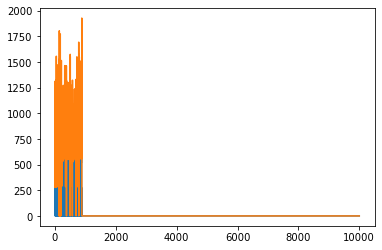

In [558]:
plt.plot(Y)

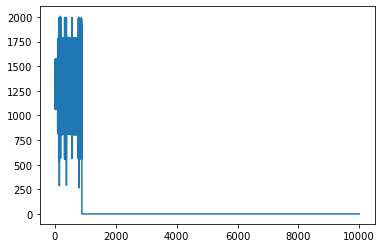

In [559]:
plt.plot(C)

In [560]:
Cp = [M[t]["Cp"] for t in range(n_iter)]
Lp = [M[t]["Lp"] for t in range(n_iter)]

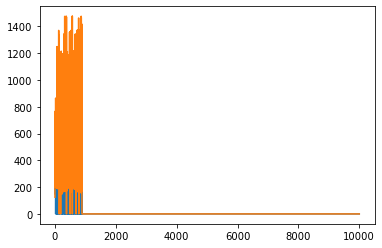

In [561]:
plt.plot(Cp)

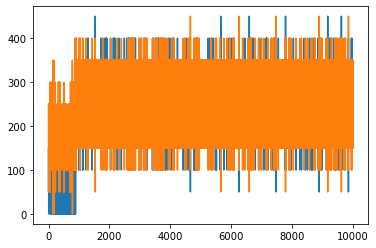

In [562]:
plt.plot(Lp)

In [537]:
M[200]

{'A': array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1]),
 'Y': [268.0064551076203, 549.7840369720968],
 'C': array([249.51259159, 243.41565887, 243.41565887,  23.21793561,
        243.41565887, 243.41565887, 244.22347956, 243.41565887,
         25.0185409 ,  35.88830093]),
 'Cp': [215.15686468645094, 809.9008649210286],
 'Lp': [50.0, 100.0],
 'R': array([0.05936498, 0.03080337, 0.03080337, 5.10467344, 0.03080337,
        0.03080337, 0.05936498, 0.03080337, 5.2483636 , 5.2483636 ])}